<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/use_cases/Location_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install -q osmnx
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.1 MB/s eta 0:00:00


- Landuse data
- POIs

In [123]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import pandas as pd

<class 'geopandas.geodataframe.GeoDataFrame'>


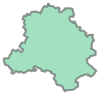

In [106]:
# Specify the name of the area (place name)
place_name = "Delhi, India"

# Get the place boundary as a GeoDataFrame
area = ox.geocode_to_gdf(place_name)

# Verify the data type
print(type(area))  # Should be geopandas.geodataframe.GeoDataFrame

aoi = area['geometry'][0]
aoi

[Get OSM features from Polygon](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon)

## Download the OSM Data

Download all the points of interests from OSM with the following tags:
`amenity`, `leisure`, `office`, `shop`, `healthcare`

Here is a comprehensive list of [OSM features](https://wiki.openstreetmap.org/wiki/Map_features)

In [114]:
POIs = ox.features.features_from_polygon(aoi, tags={'amenity':True, 'leisure':True, 'office':True, 'shop':True, 'healthcare':True}).reset_index()
POIs = POIs[POIs['geometry'].type != LineString]
POIs = POIs.to_crs('EPSG:7760')
POIs['geometry'] = POIs['geometry'].centroid
POIs = POIs.to_crs('EPSG:4326')
POIs = POIs[['osmid', 'amenity', 'name', 'geometry']]
print(f'Total points of interests found: {POIs.shape[0]}')
POIs.sample(5)

Total points of interests found: 19845


,osmid,amenity,name,geometry
13047,80950088,NaN,Safdarjung's Tomb,POINT (77.21080 28.58960)
6394,8365915118,restaurant,Haseen Biryani corner,POINT (77.29098 28.55940)
287,1374470969,cinema,INOX Vishal Mall,POINT (77.12115 28.65004)
15025,297693707,place_of_worship,Kali Temple,POINT (77.15632 28.52660)
5872,7543715707,clinic,The Maternity Clinic,POINT (77.14276 28.66448)


## Spatial Indexing the POIs


Choosing the spatial index resolution:

<img src='https://t1nak.github.io/blog/2020/h3_pics/hex_res2.png' height=300/>

In [115]:
# find hexs containing the points

APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

delhi_gdf = POIs.copy()

delhi_gdf[hex_col] = delhi_gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,x.geometry.x,APERTURE_SIZE),1)
delhi_gdf.sample(5)

,osmid,amenity,name,geometry,hex7
5782,7298752577,NaN,Gems India,POINT (77.10963 28.71942),873da18c1ffffff
11804,11814425244,NaN,Khurana Beauty,POINT (77.16854 28.58759),873da1154ffffff
10740,11688160080,place_of_worship,Ganesh Temple,POINT (77.12189 28.50908),873da111bffffff
19833,13734359,fountain,fountain area,POINT (77.23111 28.61284),873da1143ffffff
18252,988272988,NaN,MR.DIY,POINT (76.99138 28.61227),873da1124ffffff


In [126]:
delhi_gdf.groupby('hex7')['geometry'].count()

hex7
873da1001ffffff     2
873da1002ffffff     6
873da1003ffffff     1
873da1004ffffff    10
873da1005ffffff    41
                   ..
873da1c68ffffff     3
873da1c6affffff     1
873da1c6cffffff     5
873da1c6dffffff     8
873da1c6effffff     2
Name: POIs, Length: 244, dtype: int64

In [127]:
poi_density = delhi_gdf.groupby('hex7')['geometry'].count().rename('poi_count').reset_index()
poi_density.sample(5)

,hex7,poi_count
66,873da1122ffffff,16
204,873da18ecffffff,1
158,873da1891ffffff,2
168,873da189effffff,6
49,873da1105ffffff,87


In [131]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

tooltip = {
        "html": "Amenities Count: {poi_count}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

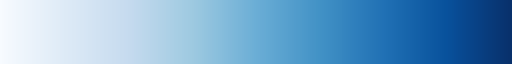

In [132]:
## Choose a colormap
cmap = colormaps['Blues']
cmap

In [133]:
## Apply the colormap to the dataframe
xdf = colormap_dataframe(df=poi_density, value_col='poi_count', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
view_state = pdk.ViewState(latitude=28.664, longitude=77.1062, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.664,
    "longitude": 77.1062,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da1001ffffff",
          "poi_count": 2
        },
        {
          "A": 100,
          "B": 254,
          "G": 250,
          "R": 246,
          "hex7": "873da1002ffffff",
          "poi_count": 6
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da1003ffffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 254,
          "G": 249,
          "R": 245,
          "hex7": "873da1004ffffff",
          "poi_count": 10
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 239,
          "hex7": "873da1005ffffff",
          "poi_count": 41
        },
        {
          "A": 100,
          "B": 254,
          "G": 250,
          "R": 246,
          "hex7": "873da1006ffffff",
          "poi_count": 7
        },
        {
          "A": 100,
          "B": 254,
          "G": 249,
          "R": 245,
          "hex7": "873da1009ffffff",
          "poi_count": 9
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da100cffffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 239,
          "hex7": "873da100dffffff",
          "poi_count": 39
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da1011ffffff",
          "poi_count": 2
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da1014ffffff",
          "poi_count": 2
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da1015ffffff",
          "poi_count": 3
        },
        {
          "A": 100,
          "B": 254,
          "G": 250,
          "R": 246,
          "hex7": "873da101cffffff",
          "poi_count": 5
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex7": "873da101effffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 245,
          "G": 231,
          "R": 216,
          "hex7": "873da1020ffffff",
          "poi_count": 151
        },
        {
          "A": 100,
          "B": 248,
          "G": 237,
          "R": 225,
          "hex7": "873da1021ffffff",
          "poi_count": 103
        },
        {
          "A": 100,
          "B": 254,
          "G": 249,
          "R": 244,
          "hex7": "873da1022ffffff",
          "poi_count": 16
        },
        {
          "A": 100,
          "B": 250,
          "G": 241,
          "R": 232,
          "hex7": "873da1023ffffff",
          "poi_count": 71
        },
        {
          "A": 100,
          "B": 249,
          "G": 239,
          "R": 229,
          "hex7": "873da1024ffffff",
          "poi_count": 85
        },
        {
          "A": 100,
          "B": 250,
          "G": 241,
          "R": 232,
          "hex7": "873da1025ffffff",
          "poi_count": 69
        },
        {
          "A": 100,
          "B": 254,
          "G": 250,
          "R": 246,
          "hex7": "873da1026ffffff",
          "poi_count": 6
        },
        {
          "A": 100,
          "B": 243,
          "G": 228,
          "R": 212,
          "hex7": "873da1028ffffff",
          "poi_count": 168
        },
        {
          "A": 100,
          "B": 224,
          "G": 200,
          "R": 155,
          "hex7": "873da1029ffffff",
          "poi_count": 370
        },
        {
          "A": 100,
     

## Accessibility

In [153]:
public_transport = ox.features.features_from_polygon(aoi, tags={'public_transport':True}).reset_index()
public_transport = public_transport.to_crs('EPSG:7760')
public_transport['geometry'] = public_transport['geometry'].centroid
public_transport = public_transport.to_crs('EPSG:4326')
public_transport = public_transport[['osmid', 'public_transport', 'name', 'geometry']]
print(f'Total points of interests found: {public_transport.shape[0]}')
public_transport.sample(4)

Total points of interests found: 3137


,osmid,public_transport,name,geometry
770,5483331740,platform,Ayurvigyan Nagar,POINT (77.22138 28.56046)
1774,6362085190,platform,Indraprastha Park,POINT (77.25442 28.60138)
662,5415760167,platform,Ansal Plaza,POINT (77.22478 28.56544)
1270,5758572045,platform,Model Basti,POINT (77.20375 28.65731)


In [154]:
public_transport['public_transport'].value_counts()

public_transport
platform         2222
stop_position     616
station           286
halt               11
yes                 2
Name: count, dtype: int64

In [157]:
highways = ox.features.features_from_polygon(aoi, tags={'highway':['primary', 'secondary']}).reset_index()

In [179]:
x = Point(77.22138, 28.56046)
highways['geometry'].distance(x)

<ipython-input-179-7dccc0916524>:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  highways['geometry'].distance(x)


0       0.110112
1       0.081127
2       0.153963
3       0.069441
4       0.051651
          ...   
4036    0.105644
4037    0.099555
4038    0.173830
4039    0.165153
4040    0.165108
Length: 4041, dtype: float64

ModuleNotFoundError: No module named 'shapely.distance'

In [176]:
x = Point(1,1)
y = LineString(((3,1), (1,3)))

gpd.GeoDataFrame([y], geometry=0, crs='EPSG:4326')[0].distance(x)

<ipython-input-176-21854ef94ab1>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.GeoDataFrame([y], geometry=0, crs='EPSG:4326')[0].distance(x)


0    1.414214
dtype: float64

0       LINESTRING (77.23162 28.67010, 77.23140 28.670...
1       LINESTRING (77.14878 28.59666, 77.14621 28.597...
2       LINESTRING (77.17638 28.71018, 77.17656 28.709...
3       LINESTRING (77.22092 28.63008, 77.22086 28.630...
4       LINESTRING (77.22762 28.61173, 77.22766 28.612...
                              ...                        
4036    LINESTRING (77.11559 28.54416, 77.11639 28.543...
4037    LINESTRING (77.12197 28.55515, 77.12166 28.555...
4038    LINESTRING (77.09437 28.67914, 77.09441 28.679...
4039    LINESTRING (77.06832 28.62608, 77.06994 28.626...
4040    LINESTRING (77.07012 28.62675, 77.07018 28.62678)
Name: geometry, Length: 4041, dtype: geometry